Data transforms that are required to transform ground truth bounding box annotations to tensors useful for training

In [53]:
import os
import torch
from torchvision.datasets import CocoDetection, wrap_dataset_for_transforms_v2
from PIL import Image, ImageDraw, ImageFont

from torch import nn
from typing import List, Tuple

from torchvision.models import get_model
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.models import ResNeXt50_32X4D_Weights
from torchvision.models._utils import IntermediateLayerGetter
from torchvision.ops.feature_pyramid_network import LastLevelP6P7

from torchvision.ops import Conv2dNormActivation
from functools import partial

import itertools


from torchvision import tv_tensors
from torchvision.transforms import v2
from typing import Any, Dict
from torchvision.transforms.v2._utils import _get_fill
from torchvision.ops import box_iou, box_convert


from yolo.visualize import render_bounding_boxes, plot
from yolo.model import YoloFPN
from yolo.data import CocoDataset, get_val_transforms

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
class Collate:
    def __call__(self, image_target_pair_list):
        
        batch_list = []
        for image, target in image_target_pair_list:
            batch_list.append({
                "image": image,
                "image_id": target["image_id"],
            })
        batch = torch.utils.data.default_collate(batch_list)
    
        batch["boxes"] = [x[1]["boxes"] for x in image_target_pair_list]
        batch["labels"] = [x[1]["labels"] for x in image_target_pair_list]
        return batch
    

val_dataset = CocoDataset(
    dataset_root = "/media/bryan/ssd01/fiftyone/coco-2017",
    split = "validation",
    transform = get_val_transforms()
)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=10,
    shuffle=False,
    pin_memory=True,
    drop_last=False,
    num_workers=0,
    collate_fn=Collate(),
)

loading annotations into memory...
Done (t=0.17s)
creating index...
index created!


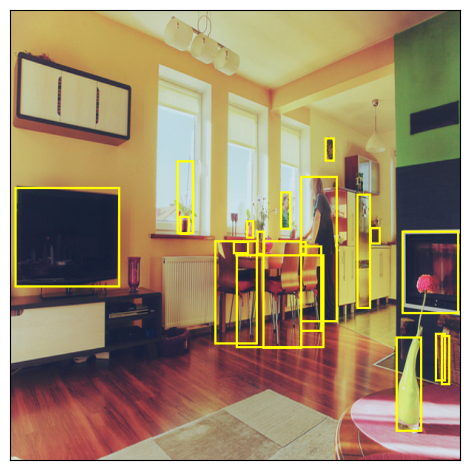

In [51]:
data = val_dataset[0]
plot([data])

In [206]:
################################
# Create a Lx4 anchor box grid
# where for an inupt image of size (416,608)
# and feature pyramids downsampling by factors x8, x16, x32 to (52,76), (26,38), (13,19)
# then L = 52*76*3 + 26*38*3 + 13*19*3
###############################

def make_spatial_anchors_per_scale(anchors_list: List[Tuple[int,int]], scale: int, image_height: int, image_width: int, verbose=False):
    """
    Create a Lx4 anchor box grid where for an inupt image of size (416,608)
    and feature pyramids downsampling by factors x8, x16, x32 to (52,76), (26,38), (13,19)
    then L = 52*76*3 + 26*38*3 + 13*19*3
    Need the anchor boxes to be in the original image resolution
    """
    
    num_anchors = len(anchors_list)
    anchor_halfs = torch.tensor(anchors_list, dtype=torch.float) / 2 # w/2, h/2

    x_axis = torch.arange(0, image_width, scale)
    y_axis = torch.arange(0, image_height, scale)
    grid_y, grid_x = torch.meshgrid(y_axis, x_axis, indexing="ij") # .shape [13,19]
    grid_xy = torch.stack([grid_x, grid_y], dim=-1) # .shape [13, 19, 2]
    grid_xy_centers = grid_xy + 0.5 * scale # center the anchor boxes in each grid cell

    # Expand grid_centers and anchors to enable broadcasting
    grid_centers_expanded = grid_xy_centers.unsqueeze(-2)  # Shape: (13, 19, 1, 2)
    anchor_halfs_expanded = anchor_halfs.unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, 3, 2)
    # Compute the upper-left xy and lower-right xy coordinates in a vectorized manner
    # to get 2x tensors of shape (13,19,3,2), then concatenated to (13,19,3,4)
    grid_anchors_xyxy = torch.cat([grid_centers_expanded - anchor_halfs_expanded, grid_centers_expanded + anchor_halfs_expanded], axis=-1)
    grid_anchors_xyxy_flatten = grid_anchors_xyxy.flatten(end_dim=-2) # .shape (13*19*3, 4)
    
    if verbose:
        print(f"[make_spatial_anchors][scale: /{scale}] image resized from ({image_height}, {image_width}) to ({image_height / scale}, {image_width / scale})")
        s1,s2,s3 = grid_anchors_xyxy.shape[:3]
        print(f"[make_spatial_anchors][scale: /{scale}] L={s1}x{s2}x{s3}={s1*s2*s3} spatial_anchors is (L,4)={tuple(grid_anchors_xyxy_flatten.shape)}")
    return grid_anchors_xyxy_flatten


def make_spatial_anchors(anchors_list: List[Tuple[int,int]], scales: List[int], image_height: int, image_width: int, num_anchors_per_scale: int = 3, verbose: bool=False):
    anchors_per_scale = list(itertools.batched(anchors_list, num_anchors_per_scale))
    spatial_anchors_per_scale = [make_spatial_anchors_per_scale(anchors, scale, image_height, image_width, verbose = verbose) for anchors, scale in zip(anchors_per_scale, scales)]
    spatial_anchors = torch.cat(spatial_anchors_per_scale, axis=0)
    return spatial_anchors



def make_scale_map(scales: List[int], image_height: int, image_width: int, num_anchors_per_scale: int = 3):
    # scale at each position (L,)
    return torch.cat([torch.full((int(image_height * image_width*num_anchors_per_scale / scale**2), ), scale) for scale in scales])

In [216]:
scale_map = make_scale_map(SCALES, 608, 608)
from collections import Counter
Counter(scale_map.tolist())

Counter({8: 17328, 16: 4332, 32: 1083})

In [215]:
ANCHORS = [
    (10,13),
    (16,30),
    (33,23),
    (30,61),
    (62,45),
    (59,119),
    (116,90),
    (156,198),
    (373,326)
]
SCALES = [8, 16, 32] # factor by which the input image is downsampled at each FPN
spatial_anchors = make_spatial_anchors(ANCHORS, SCALES, 608, 608, verbose=True)
print("spatial_anchors.shape: ", spatial_anchors.shape)

[make_spatial_anchors][scale: /8] image resized from (608, 608) to (76.0, 76.0)
[make_spatial_anchors][scale: /8] L=76x76x3=17328 spatial_anchors is (L,4)=(17328, 4)
[make_spatial_anchors][scale: /16] image resized from (608, 608) to (38.0, 38.0)
[make_spatial_anchors][scale: /16] L=38x38x3=4332 spatial_anchors is (L,4)=(4332, 4)
[make_spatial_anchors][scale: /32] image resized from (608, 608) to (19.0, 19.0)
[make_spatial_anchors][scale: /32] L=19x19x3=1083 spatial_anchors is (L,4)=(1083, 4)
spatial_anchors.shape:  torch.Size([22743, 4])


In [63]:
batch = next(iter(val_dataloader))

In [88]:
batch_size = len(batch["boxes"])
# >= 0 index into gt boxes (highest IOU) per image
# -1: ignore (IOU > 0.5)
# -2: negative examples. anchors with IOU <= 0.5
spatial_anchor_mask = -torch.ones(batch_size, len(spatial_anchors), dtype=torch.long)
print("spatial_anchor_mask.shape: ", spatial_anchor_mask.shape)

spatial_anchor_mask.shape:  torch.Size([10, 22743])


In [166]:
def make_spatial_anchor_mask(boxes_per_image, spatial_anchors, verbose = False):
    batch_size = len(boxes_per_image)

    if verbose:
        print(f"[make_spatial_anchor_mask] spatial_anchors.shape {tuple(spatial_anchors.shape)}")
        num_boxes_per_image = [len(x) for x in boxes_per_image]
        num_boxes = sum(num_boxes_per_image)
        print(f"[make_spatial_anchor_mask][batch_size {batch_size}][# boxes {num_boxes}] boxes per image: {num_boxes_per_image}")
    
    # >= 0 index into gt boxes (highest IOU) per image
    # -1: ignore (IOU > 0.5)
    # -2: negative examples. anchors with IOU <= 0.5
    spatial_anchor_mask = -2 * torch.ones(batch_size, len(spatial_anchors), dtype=torch.long)
    
#     num_iou_gt_05 = 0
#     num_iou_lt_05 = 0
#     num_max_iou = 0
    
    for image_idx, boxes in enumerate(boxes_per_image):
        # both sets of boxes are expected to be in (x1, y1, x2, y2) format with 0 <= x1 < x2 and 0 <= y1 < y2.
        ious = box_iou(boxes, spatial_anchors)
        # ignore anchors that match, but aren't the maximum
        _, anchor_idx = torch.where(ious > 0.5)
        spatial_anchor_mask[image_idx, anchor_idx] = -1
        
#         # Debugging
#         this_num_iou_gt_05 = torch.sum(ious > 0.5)
#         assert this_num_iou_gt_05 == len(anchor_idx)
        
        # Find the max value per row
        max_ious, _ = torch.max(ious, dim=1, keepdim=True)
        # Compare each element to the max value and get the indices of all elements that match the max value
        box_idx, anchor_idx = (ious == max_ious).nonzero(as_tuple=True)
        spatial_anchor_mask[image_idx, anchor_idx] = box_idx
        if verbose:
            print(f"[make_spatial_anchor_mask][image {image_idx}][# boxes {len(boxes)}][# best match {len(anchor_idx)}]")
        
#         # For debugging
#         this_num_iou_lt_05 = torch.sum(ious <= 0.5)
#         assert this_num_iou_gt_05 +  this_num_iou_lt_05 == ious.numel()
#         print(f"[image {image_idx}] before accounting for max_iou boxes [{this_num_iou_gt_05} >0.5][{this_num_iou_lt_05} <= 0.5]")
#         for this_box_idx, this_anchor_idx in zip(box_idx, anchor_idx):
#             max_iou_val = ious[this_box_idx, this_anchor_idx]
#             if max_iou_val > 0.5:
#                 this_num_iou_gt_05 -= 1
#             else:
#                 this_num_iou_lt_05 -= 1
#         assert ious.numel() - this_num_iou_gt_05 - this_num_iou_lt_05 == len(anchor_idx)
#         print(f"[image {image_idx}] after accounting for max_iou boxes [{this_num_iou_gt_05} >0.5][{this_num_iou_lt_05} <= 0.5]") 
#         num_iou_gt_05 += this_num_iou_gt_05
#         num_iou_lt_05 += this_num_iou_lt_05
#         num_max_iou += len(anchor_idx)
#     print(f"num_iou_gt_05: {num_iou_gt_05}")
#     print(f"num_iou_lt_05: {num_iou_lt_05}")
#     print(f"num_max_iou: {num_max_iou}")
    
    if verbose:
        num_best_match = torch.sum(spatial_anchor_mask >= 0).item()
        num_gt_05 = torch.sum(spatial_anchor_mask == -1).item()
        num_lt_05 = torch.sum(spatial_anchor_mask == -2).item()
        print(f"[make_spatial_anchor_mask] spatial_anchor_mask.shape {tuple(spatial_anchor_mask.shape)} [{num_best_match} #best_match][{num_gt_05} # >0.5][{num_lt_05} # <=0.5]")

    return spatial_anchor_mask


In [184]:
spatial_anchor_mask = make_spatial_anchor_mask(batch["boxes"], spatial_anchors, verbose=True)

[make_spatial_anchor_mask] spatial_anchors.shape (22743, 4)
[make_spatial_anchor_mask][batch_size 10][# boxes 81] boxes per image: [20, 1, 18, 4, 4, 2, 2, 4, 9, 17]
[make_spatial_anchor_mask][image 0][# boxes 20][# best match 41]
[make_spatial_anchor_mask][image 1][# boxes 1][# best match 49]
[make_spatial_anchor_mask][image 2][# boxes 18][# best match 45]
[make_spatial_anchor_mask][image 3][# boxes 4][# best match 5]
[make_spatial_anchor_mask][image 4][# boxes 4][# best match 99]
[make_spatial_anchor_mask][image 5][# boxes 2][# best match 41]
[make_spatial_anchor_mask][image 6][# boxes 2][# best match 5]
[make_spatial_anchor_mask][image 7][# boxes 4][# best match 24]
[make_spatial_anchor_mask][image 8][# boxes 9][# best match 36]
[make_spatial_anchor_mask][image 9][# boxes 17][# best match 111]
[make_spatial_anchor_mask] spatial_anchor_mask.shape (10, 22743) [398 #best_match][168 # >0.5][226864 # <=0.5]


torch.return_types.topk(
values=tensor([[0.5549, 0.5549, 0.5549, 0.5549, 0.5549],
        [0.8013, 0.8013, 0.7863, 0.7465, 0.6937],
        [0.4976, 0.4976, 0.4976, 0.4976, 0.4976],
        [0.3301, 0.3301, 0.3301, 0.3301, 0.3301]]),
indices=tensor([[22085, 22082, 22088, 22136, 22079],
        [22424, 22421, 22427, 22418, 22478],
        [21980, 21983, 22034, 22037, 21977],
        [21968, 21965, 21971, 21977, 21974]]))

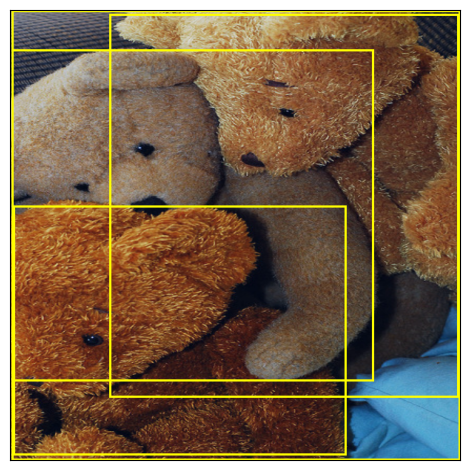

In [182]:
# Image with a lot of matching ground truth boxes
data = val_dataset[4]
plot([data])

ious = box_iou(batch["boxes"][4], spatial_anchors)
ious.topk(5)

In [189]:
spatial_anchor_mask.shape

torch.Size([10, 22743])

In [ ]:
# Encode the ground truth bounding boxes to tx_ty_tw_th. Also need the scale factor

In [198]:
boxes_list = batch["boxes"]

In [218]:
boxes_list[0] / 32

tensor([[ 7.0353,  6.3561,  7.7686,  9.4558],
        [ 0.2087,  7.4823,  4.6416, 11.7135],
        [16.5422,  9.3301, 18.9573, 12.8415],
        [10.6572,  9.7252, 12.3197, 14.3115],
        [ 8.6299,  9.7230, 10.4654, 14.1153],
        [12.2669,  9.9465, 13.1625, 13.5752],
        [ 9.4228,  9.7783, 10.0635, 10.2952],
        [12.2550,  7.0296, 13.8299, 13.1849],
        [11.4128,  7.6807, 11.8616,  9.2748],
        [15.2065,  9.1766, 15.6441,  9.8889],
        [14.6389,  7.7757, 15.2413, 12.6065],
        [17.9541, 13.6430, 18.3798, 15.6817],
        [18.2056, 13.7478, 18.5879, 15.8191],
        [13.2932,  5.4021, 13.7079,  6.3779],
        [16.3002, 13.8009, 17.3892, 17.8002],
        [10.4132,  9.3145, 10.7507, 10.3202],
        [12.2387,  9.7685, 12.5246, 10.3269],
        [ 7.1618,  8.6967,  7.5840,  9.4831],
        [ 9.9985,  8.8979, 10.2873,  9.6441],
        [ 9.5359, 10.3126, 13.2635, 14.2790]])

In [240]:
# Also need a map (L,2) to the anchor


def encode_box(box_xyxy, scale, anchor, epsilon=1e-5):
    # box is expected to be in (x1, y1, x2, y2) format with 0 <= x1 < x2 and 0 <= y1 < y2.
    # epsilon is to handle the case of log(0) = -inf
    bxy = box_xyxy[:2] / scale
    qxy = torch.frac(bxy) + epsilon
    # qxy = sigmoid(txty)
    txy = torch.log(qxy / (1 - qxy))
    
    # epsilon isn't required since width of the box has to be greater than 0
    bwh = box_xyxy[2:4] - box_xyxy[:2] 
    # anchor should be xy

    twh = torch.log(bwh / anchor)
    txywh = torch.cat([txy,twh])
    return txywh


bbox = torch.tensor([236.9800, 142.5100,  236.9800 + 24.7000,  142.5100 + 69.5000])
anchors = torch.tensor([30, 61]) # w, h
encode_box(bbox, 32, anchors)

tensor([-0.3820, -0.1868, -0.1944,  0.1305])

In [191]:
# Now we want to create a ground truth box encoding matrix of shape (N,L,4)

selected_gt_txtytwth = []
for batch_idx, L_idx in zip(*torch.where(spatial_anchor_mask >= 0)):
    box_idx = spatial_anchor_mask[batch_idx,L_idx]
    print(f"N={batch_idx}, box_idx={box_idx}")
#     selected_gt_txtytwth.append(gt_txtytwth[batch_idx][box_idx])
# selected_gt_txtytwth = torch.stack(selected_gt_txtytwth)

N=0, box_idx=13
N=0, box_idx=8
N=0, box_idx=8
N=0, box_idx=17
N=0, box_idx=18
N=0, box_idx=18
N=0, box_idx=9
N=0, box_idx=15
N=0, box_idx=6
N=0, box_idx=6
N=0, box_idx=16
N=0, box_idx=12
N=0, box_idx=12
N=0, box_idx=12
N=0, box_idx=12
N=0, box_idx=0
N=0, box_idx=0
N=0, box_idx=10
N=0, box_idx=7
N=0, box_idx=10
N=0, box_idx=7
N=0, box_idx=10
N=0, box_idx=7
N=0, box_idx=10
N=0, box_idx=7
N=0, box_idx=10
N=0, box_idx=5
N=0, box_idx=7
N=0, box_idx=10
N=0, box_idx=2
N=0, box_idx=4
N=0, box_idx=3
N=0, box_idx=5
N=0, box_idx=4
N=0, box_idx=3
N=0, box_idx=5
N=0, box_idx=11
N=0, box_idx=14
N=0, box_idx=1
N=0, box_idx=1
N=0, box_idx=19
N=1, box_idx=0
N=1, box_idx=0
N=1, box_idx=0
N=1, box_idx=0
N=1, box_idx=0
N=1, box_idx=0
N=1, box_idx=0
N=1, box_idx=0
N=1, box_idx=0
N=1, box_idx=0
N=1, box_idx=0
N=1, box_idx=0
N=1, box_idx=0
N=1, box_idx=0
N=1, box_idx=0
N=1, box_idx=0
N=1, box_idx=0
N=1, box_idx=0
N=1, box_idx=0
N=1, box_idx=0
N=1, box_idx=0
N=1, box_idx=0
N=1, box_idx=0
N=1, box_idx=0
N=1, b